In [1]:
!pip install gym==0.19

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.1 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for gym: filename=gym-0.19.0-py3-none-any.whl size=1663088 sha256=8c7807f35b2b3148926b357bdd7d31d08981745bc016c734a9bdee9598449590
  Stored in directory: /root/.cache/pip/wheels/7f/06/dd/dd2b81c5f1f7e0f35a0042237735bdd286c0643c3cbcf23667
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.2.0
    Uninstalling cloudpickle-2.2.0:
      Successfully uninstalled cloudpickle-2.2.0


In [2]:
#! wget http://www.atarimania.com/roms/Roms.rar
#! mkdir ROM/
#! unrar e Roms.rar ROM/ -y

In [3]:
!pip uninstall atari_py atari-py -y

In [4]:
!pip3 install atari-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 51.5 MB/s eta 0:00:0000:01


In [5]:
! python3 -m atari_py.import_roms ROM/

copying private_eye.bin from ROM/Private Eye.bin to /usr/local/lib/python3.9/dist-packages/atari_py/atari_roms/private_eye.bin
copying riverraid.bin from ROM/River Raid.bin to /usr/local/lib/python3.9/dist-packages/atari_py/atari_roms/riverraid.bin
copying pong.bin from ROM/Video Olympics - Pong Sports (Paddle) (1977) (Atari, Joe Decuir - Sears) (CX2621 - 99806, 6-99806, 49-75104) ~.bin to /usr/local/lib/python3.9/dist-packages/atari_py/atari_roms/pong.bin
copying sir_lancelot.bin from ROM/Sir Lancelot (1983) (Xonox - K-Tel Software - Product Guild, Anthony R. Henderson) (99006, 6220) (PAL).bin to /usr/local/lib/python3.9/dist-packages/atari_py/atari_roms/sir_lancelot.bin
copying ms_pacman.bin from ROM/Ms. Pac-Man (1983) (Atari - GCC, Mark S. Ackerman, Patricia Goodson, Josh Littlefield, Douglas B. Macrae, Glenn Parker) (CX2675) ~.bin to /usr/local/lib/python3.9/dist-packages/atari_py/atari_roms/ms_pacman.bin
copying air_raid.bin from ROM/Air Raid (PAL).bin to /usr/local/lib/python3.9/

In [6]:
from collections import defaultdict
from time import sleep
import numpy as np
import cv2
import gym

def cellfn(frame):
    #cell = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    cell = cv2.resize(frame, (8, 8), interpolation = cv2.INTER_AREA)
    cell = cell // 32
    return cell

def hashfn(cell):
    return hash(cell.tobytes())

class Weights:
    times_chosen = 0.1
    times_chosen_since_new = 0
    times_seen = 0.3

class Powers:
    times_chosen = 0.5
    times_chosen_since_new = 0.5
    times_seen = 0.5

class Cell(object):
    def __init__(self):
        self.times_chosen = 0
        self.times_chosen_since_new = 0
        self.times_seen = 0

    def __setattr__(self, key, value):
        object.__setattr__(self, key, value)
        if key != 'score' and hasattr(self, 'times_seen'):
            self.score = self.cellscore()

    def cntscore(self, a):
        w = getattr(Weights, a)
        p = getattr(Powers, a)
        v = getattr(self, a)
        return w / (v + e1) ** p + e2

    def cellscore(self):
        return self.cntscore('times_chosen')           +\
               self.cntscore('times_chosen_since_new') +\
               self.cntscore('times_seen')             +\
               1

    def visit(self):
        self.times_seen += 1
        return self.times_seen == 1

    def choose(self):
        self.times_chosen += 1
        self.times_chosen_since_new += 1
        return self.ram, self.reward, self.trajectory

In [7]:
import numpy as np
from collections import deque
import gym
from gym import spaces
import cv2
cv2.ocl.setUseOpenCL(False)

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255,
            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[0], shp[1], shp[2] * k), dtype=np.uint8)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=2)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

def make_atari(env_id):
    env = gym.make(env_id)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    return env

def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env



class ImageToPyTorch(gym.ObservationWrapper):
    """
    Image shape to num_channels x weight x height
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)
    

def wrap_pytorch(env):
    return ImageToPyTorch(env)

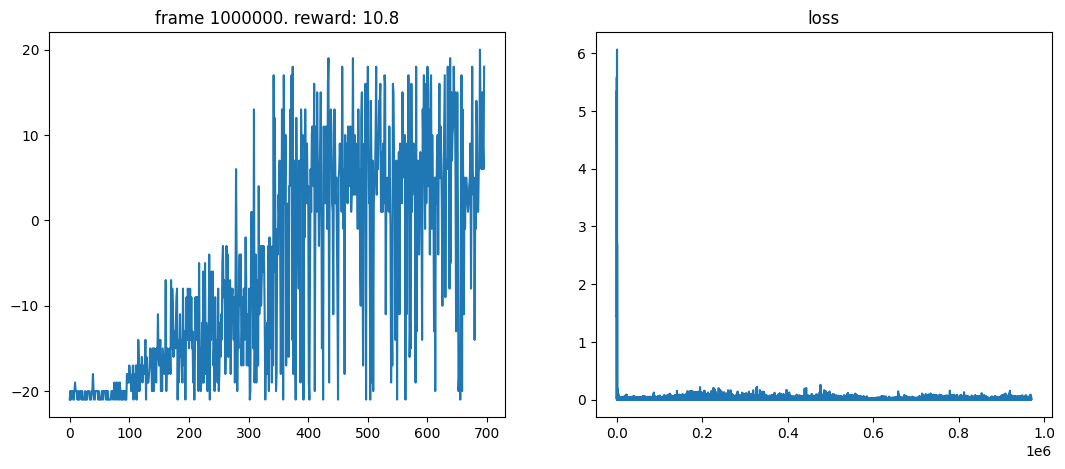

In [8]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

from collections import deque

env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    next_q_state_values = target_model(next_state) 

    q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1) 
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

def plot(frame_idx, rewards, losses):
    rewards_tensor = torch.tensor(rewards)
    rewards = rewards_tensor.cpu()
    rewards = np.array(rewards)
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    losses = torch.tensor(losses)
    plt.plot(losses)
    plt.show()

class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

current_model = CnnDQN(env.observation_space.shape, env.action_space.n)
target_model  = CnnDQN(env.observation_space.shape, env.action_space.n)

#current_model.load_state_dict(torch.load('DoubleDQN_Go_Explore'))
#target_model.load_state_dict(torch.load('DoubleDQN_Go_Explore'))

go_explore = True

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), lr=0.0001)

replay_initial = 30000
replay_buffer = ReplayBuffer(100000)

def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

update_target(current_model, target_model)

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

plt.plot([epsilon_by_frame(i) for i in range(1000000)])

num_frames = 1000000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

archive = defaultdict(lambda: Cell())
highscore = 0
frames = 0

e1 = 0.001
e2 = 0.00001

state = env.reset()
score = 0
trajectory = []
iterations = 0
found_new_cell = False
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    score += reward
    trajectory.append(action)
    frames += 1
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward

    if score > highscore:
        highscore = score
    
    if done:
        if go_explore:
            if found_new_cell and iterations > 0:
                restore_cell.times_chosen_since_new = 0

            iterations += 1
            scores = np.array([cell.score for cell in archive.values()])
            hashes = [*archive]
            probs = scores / scores.sum()
            restore = np.random.choice(hashes, p = probs)
            restore_cell = archive[restore]
            ram, score, trajectory = restore_cell.choose()
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = score
            found_new_cell = False

            print ("Iterations: %d, Cells: %d, Frames: %d, Go Reward: %d" % (iterations, len(archive), frames, highscore))
            print ("Mean Reward:", np.mean(all_rewards[-10:]), "Eplison", epsilon)
            episode_reward = 0
            score = 0
            cellhashes = []
            done = False
            for i in trajectory:
                next_state, reward, done, _ = env.step(i)
                state = next_state
                score += reward
                episode_reward += reward
                if done:
                    state = env.reset()
                    episode_reward = 0
                    score = 0
                    trajectory = []
                else:
                    frame = state.reshape((84, 84, 1))
                    cell = cellfn(frame)
                    cellhash = hashfn(cell)
                    cell = archive[cellhash]
                    first_visit = cell.visit()
                    if first_visit or score > cell.reward or score == cell.reward and len(trajectory) < len(cell.trajectory):
                        cell.ram = cellhash
                        cell.reward = score
                        cell.trajectory = trajectory.copy()
                        cell.times_chosen = 0
                        cell.times_chosen_since_new = 0
        else:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0
            print ("Mean Reward:", np.mean(all_rewards[-10:]), "Eplison", epsilon)
    else:
        frame = state.reshape((84, 84, 1))
        cell = cellfn(frame)
        cellhash = hashfn(cell)
        cell = archive[cellhash]
        first_visit = cell.visit()
        if first_visit or score > cell.reward or score == cell.reward and len(trajectory) < len(cell.trajectory):
            cell.ram = env.env.clone_full_state()
            cell.reward = score
            cell.trajectory = trajectory.copy()
            cell.times_chosen = 0
            cell.times_chosen_since_new = 0
            found_new_cell = True
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.data)
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)
        torch.save(current_model.state_dict(), 'DoubleDQN_Go_Explore')
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)